# Detecção de outliers
Pode ser interessante detectar outliers entre os clientes da feira para descobrir possíveis compradores que sejam pessoas jurídicas que realizam compras com o intuito de revenda. Caso encontrados, algum tipo de convênio poderia ser firmado com tais clientes.<p>

## Primeira abordagem
Faremos esta análise utilizando DBSCAN para agrupar clientes por meio do valor total gasto e da quantidade total de produtos adquiridos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [2]:
df = pd.read_csv('arquivos/clientes_final.csv')
df = df.filter(['id_cliente','vl_total_compras','qt_total_itens','qt_tot_pedidos'])
df.head()

,id_cliente,vl_total_compras,qt_total_itens,qt_tot_pedidos
0,31,2109.05,214,12
1,33,290.80,34,4
2,34,9108.60,882,12
3,35,774.05,69,4
4,36,190.80,32,3


Vamos determinar nosso X e normalizar seus dados, já que tratar-se-á de duas colunas que utilizam unidades diferentes. A coluna de identificação do cliente será reutilizada posteriormente.

In [3]:
X = df[['vl_total_compras','qt_total_itens','qt_tot_pedidos']]

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

O DBSCAN se utiliza do conceito de densidade dos pontos para separá-los em agrupamentos. Para calcular esta densidade, existem dois hiper parâmetros:
- epsilon (eps), que determina a distância estendida de um ponto;
- número mínimo de pontos (ms) que devem estar dentro do raio determinado por epsilon para que um ponto seja considerado um ponto *core*. Pontos *core* fazem parte de um cluster. Pontos que não estiverem ao alcance de nenhum ponto são considerados outliers. Caso um ponto tenha ao menos um ponto dentro de seu raio, porém não atinja o número mínimo, será um ponto *border*, e não será considerado um outlier.<p>

Posto isto, iremos determinar que o número mínimo de pontos será 4 (o dobro da quantidade de parâmetros) e tentaremos descobrir o melhor valor para epsilon, que reduza a quantidade de outliers para um percentual analisável.

In [4]:
percent_outliers = list()
ms = scaled_X.shape[1] * 2

lista_eps = np.linspace(0.001,3,50) # 50 valores que testaremos para eps

for eps in lista_eps:
    modelo = DBSCAN(min_samples=ms,eps=eps)
    modelo.fit(scaled_X)
    
    nr_outliers = np.sum(modelo.labels_ == -1) # DBSCAN atribui label -1 aos outliers
    perc_outliers = 100 * nr_outliers / len(modelo.labels_)
    percent_outliers.append(perc_outliers)

Agora vamos visualizar o percentual de outliers para cada valor testado para epsilon, o que nos ajudará a escolher o seu valor final.

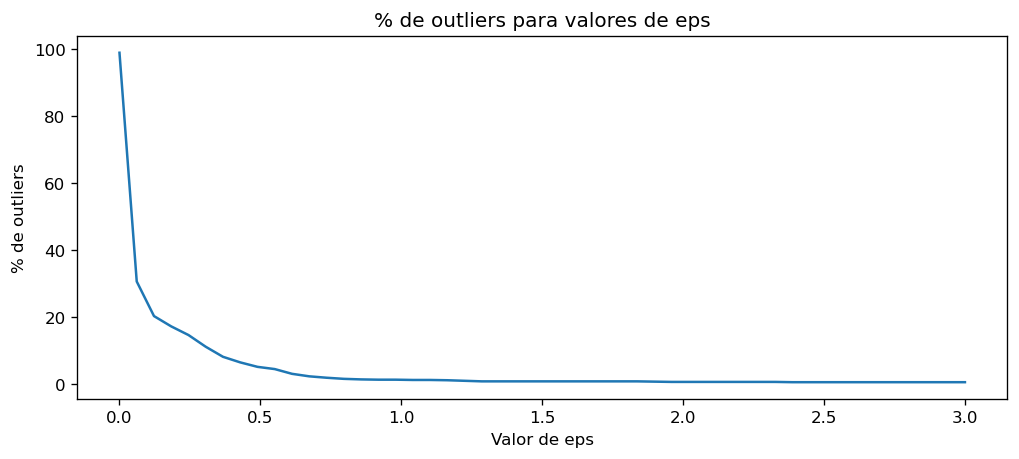

In [5]:
plt.figure(dpi=120,figsize=(10,4))
ax = sns.lineplot(x=lista_eps,y=percent_outliers)
ax.set(xlabel='Valor de eps',ylabel='% de outliers',title='% de outliers para valores de eps');

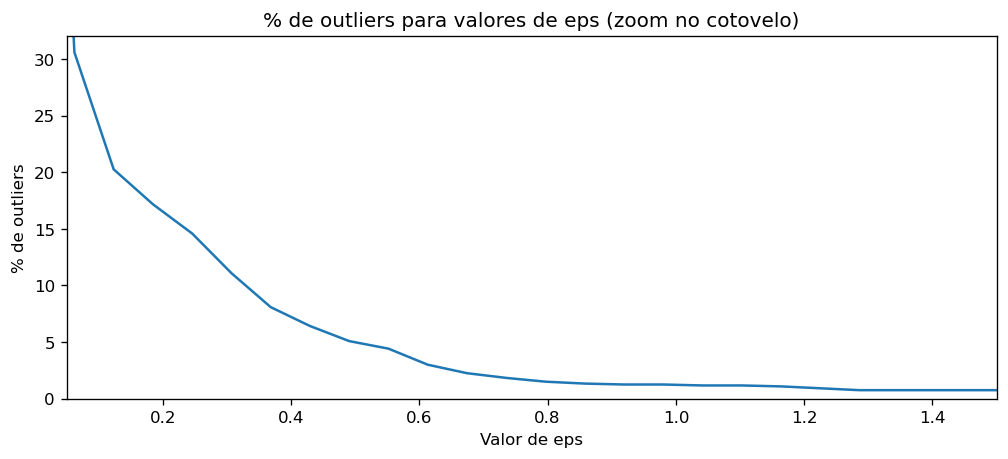

In [6]:
plt.figure(dpi=120,figsize=(10,4))
ax = sns.lineplot(x=lista_eps,y=percent_outliers)
ax.set(xlabel='Valor de eps',ylabel='% de outliers',title='% de outliers para valores de eps (zoom no cotovelo)')
plt.xlim(0.05,1.5)
plt.ylim(0,32);

Como temos 1.200 clientes, selecionaremos 1.0 para epsilon, caso contrário teremos uma lista muito grande de outliers, o que pode acabar se tornando difícil de analisar. Vamos treinar nosso modelo.

In [7]:
modelo = DBSCAN(min_samples=ms,eps=1)
labels = modelo.fit_predict(scaled_X)
df['label'] = labels
df['label'].value_counts()

 0    1185
-1      15
Name: label, dtype: int64

Podemos verificar que foi criado somente um cluster com 1.185 clientes, restando 15 como ouliers. Vale salientar que, dependo dos hiperparâmetros que utilizássemos, poderiam ter sido criados mais clusteres.<p>
Como nosso X é tri-dimensional, podemos plotar os dados em um scatter plot 3D e verificar como foram agrupados os clientes.<P>
Obs.: para o comando a seguir funcionar, é preciso instalar o pacote *ipympl*.

In [8]:
%matplotlib widget

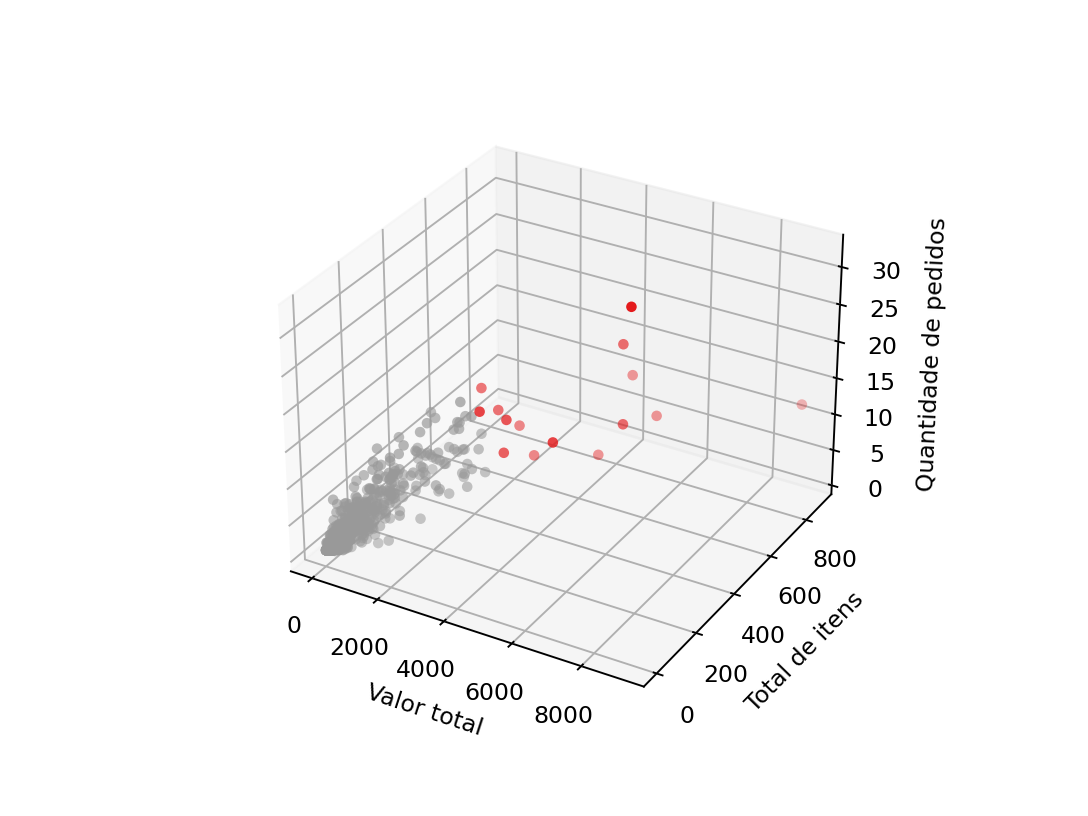

In [9]:
fig = plt.figure(dpi=170)
ax = fig.add_subplot(projection='3d')
ax.scatter(df['vl_total_compras'],df['qt_total_itens'],df['qt_tot_pedidos'],c=df['label'],cmap='Set1',linewidth=0)
ax.set(xlabel='Valor total',ylabel='Total de itens',zlabel='Quantidade de pedidos')
plt.show()

A princípio é possível imaginar que tal análise poderia ter sido feita simplesmente com a plotagem dos dados num gráfico, mas a utilização de DBSCAN, que acrescentou um label a cada cliente, facilita a visualização dos clientes no DataFrame, como podemos ver a seguir.

In [10]:
df[df['label'] == -1]

,id_cliente,vl_total_compras,qt_total_itens,qt_tot_pedidos,label
2,34,9108.60,882,12,-1
15,47,6507.90,431,32,-1
39,72,6070.00,471,15,-1
43,78,3339.30,221,19,-1
76,116,2549.90,355,18,-1
164,217,5547.00,561,23,-1
166,220,3768.40,265,13,-1
190,246,3750.10,282,17,-1
242,301,5157.00,276,16,-1
270,333,5190.60,498,9,-1


A partir da tabela acima é possível ver se esses clientes compram uma quantidade muito grande de um produto específico, como exemplificado a seguir.<p>
Perceba que a fonte de dados é outra. Até então estávamos lendo dados de cliente e, para esta análise, leremos dados de pedidos no formato long.

In [11]:
df_pl = pd.read_csv('arquivos/pedidos_long_final.csv')

In [14]:
pd.set_option("display.max_rows",75)
df_pl[df_pl['id_cliente'] == 34].groupby(['id_cliente','nome_produto']).sum(
    'qt_itens').sort_values('qt_itens',ascending=False)[['qt_itens','vl_total']]

qt_itens  \
id_cliente nome_produto                                                   
34         goma fresca para tapioca                                  66   
           agua de coco                                              61   
           couve                                                     58   
           limao                                                     53   
           carne de porco                                            36   
           alface crespa                                             32   
           castanha de caju (natural)                                31   
           cafe                                                      31   
           milho verde                                               30   
           linguica artesanal - tradicional                          26   
           mamao                                                     26   
           queijo coalho (500g)                                      26   
           banana prata                                              24   
           castanha de caju (salgada)                                21   
           cocada branca                                             20   
           batata doce                                               19   
           ovos caipira                                              18   
           linguica artesanal - condimentada                         17   
           linguica artesanal - apimentada                           17   
           suco de uva                                               17   
           feijao verde                                              17   
           toucinho de porco                                         17   
           banana maca                                               16   
           carne de carneiro                                         15   
           berin                                                     14   
           macaxeira                                                 11   
           mascara de tecido mst - cor vermelha                      10   
           galinha caipira                                            9   
           queijo coalho                                              8   
           cajuina                                                    7   
           alho temperado                                             7   
           doce de leite                                              7   
           fava                                                       7   
           feijao de corda                                            7   
           arroz                                                      6   
           arroz branco - agulhinha (5kg)                             6   
           macaxeira pre-cozida                                       6   
           acucar mascavo organico                                    6   
           rapadura de caju                                           5   
           coco seco                                                  5   
           farinha de mandioca amarela                                4   
           mel de abelha                                              4   
           goma                                                       4   
           jerimum caboclo                                            4   
           mascara de tecido mst - cor branca                         4   
           palitos de cana-de-acucar                                  4   
           melancia                                                   3   
           cafe guaii moido (500g)                                    3   
           gordura de porco                                           3   
           farinha de mandioca branca                                 3   
           camisa mst (tamanho                                        2   
           manteiga da terra                                          2   
           fa

In [13]:
pd.set_option("display.max_rows",10)